In [14]:
%%html
<style>
table {display: block;}
td {
  font-size: 18px
}
.rendered_html { font-size: 28px; }
*{ line-height: 200%; }
</style>

# Welcome to the <span style="color:blue">Natural Language Processing and the Web WS2022/23</span> 
#  **Practical Class 7: Image Capitoning**

### Adapted from the practice class Xintong Wang delivered last year


## **Introduction**:

Image captioning aims to convert a given input image into a <span style="color:blue">natural language description</span>. The encoder-decoder framework is widely used for this task. The image encoder is a <span style="color:blue">convolutional neural network (CNN)</span>. The decoder is a <span style="color:blue">long short-term memory (LSTM)</span> network.


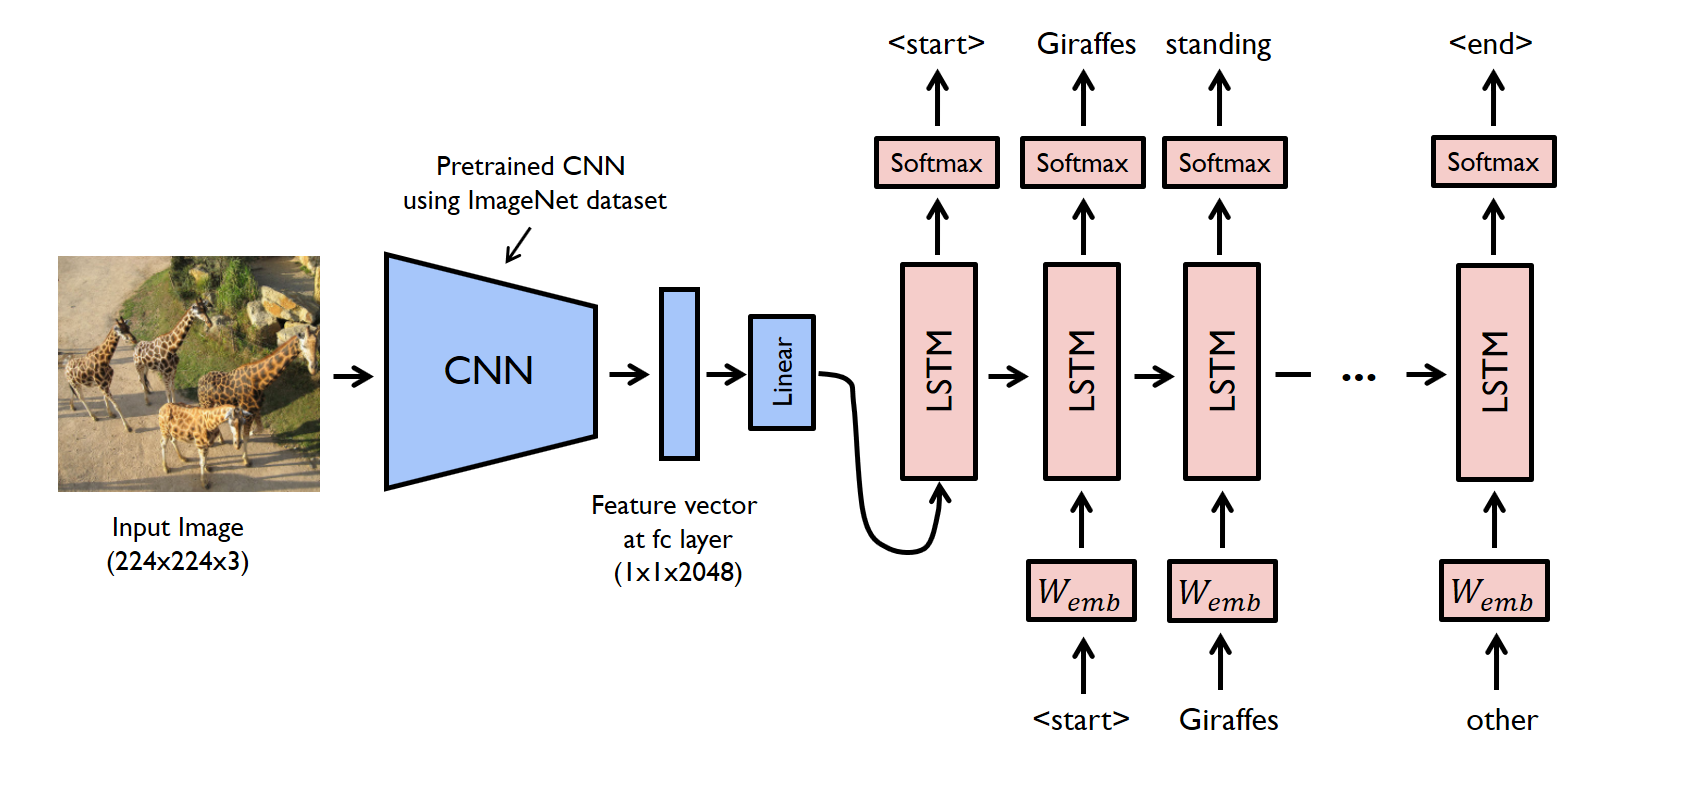




### Training phase

For the encoder part, the pretrained CNN extracts the feature vector from a given input image. The feature vector is linearly transformed to have the same dimension as the input dimension of the LSTM network. For the decoder part, source and target texts are predefined. For example, if the image description is `Giraffes standing next to each other`, the source sequence is a list containing [`<start>`, `Giraffes`, `standing`, `next`, `to`, `each`, `other`] and the target sequence is a list containing [`Giraffes`, `standing`, `next`, `to`, `each`, `other`, `<end>`]. Using these source and target sequences and the feature vector, the LSTM decoder is trained as a <span style="color:blue">language model</span> conditioned on the feature vector.

### Testing phase

In the test phase, the encoder part is almost same as the training phase. For the decoder part, there is a significant difference between the training phase and the test phase. <span style="color:blue">In the test phase, the LSTM decoder can't see the image description</span>. To deal with this problem, the LSTM decoder feeds back the <span style="color:blue">previosly generated word</span> to the next input.!!!



### Inference phase

In this phase, users could input any images and get the caption for each image using the model we already trained.

## Goal for this practice class:


1.   Understand the standard process to implement image captioning model.
2.   Understand the pipline for deep learning.
3.   Understand the difference among training, testing, and inference.

<span style="color:blue">Assignment</span> for this class will be one question (5 scores) and two extra coding parts (10 scores).





# **GPU and Dataset Preparation**

### **GPU Preparation**

<span style="color:blue">Colab provides you 12 hours GPU usage, 12G.</span>

First of all, make sure this tutorial and your assignment is running on GPU environment. Otherwise, it would be pretty slow to train you model. 

If your GPU environment is ready to use, use command `!nvidia-smi` to monitor as following.


`
!nvidia-smi
`




In [15]:
!nvidia-smi

Wed Dec  7 14:35:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8    15W / 220W |   1950MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In this practical class, we will use PyTorch Framework. Make sure PyTorch is installed in your environment. To install the appropriate PyTorch, check cuda version first.

`# !nvcc --version`

OR in your local linux machine as:

` 
!cat /usr/local/cuda/version.txt
`

In [16]:
!cat /usr/local/cuda/version.txt

'cat' is not recognized as an internal or external command,
operable program or batch file.



This result tells us that cuda that is running on our server is version <span style="color:blue">11</span>

But please ensure to check it yourself in your Google Colab env. Because your running environment may different from where the notebook is running here.

[PyTorch Install Link:](https://pytorch.org/get-started/locally/)

If your environment is the same with this notebook, then the install command will be:

```
!pip install torch==1.10.0+cu111 torchvision==0.11.1+cu111 torchaudio==0.10.0+cu111 -f https://download.pytorch.org/whl/cu111/torch_stable.html

```

 <span style="color:blue">Sidenote</span>: If you want to use conda package management, you should install miniconda or anaconda first. Otherwise, you should use pip.


In [17]:
!pip install torch==1.10.0+cu111 torchvision==0.11.1+cu111 torchaudio==0.10.0+cu111 -f https://download.pytorch.org/whl/cu111/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html


ERROR: Could not find a version that satisfies the requirement torch==1.10.0+cu111 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0)
ERROR: No matching distribution found for torch==1.10.0+cu111


How to check if pytorch is installed successfully?



```
import torch
```
If you could import it, then you succesfully install it.

*Note: the package of PyTorch is called torch.*

In [18]:
import torch

### Dataset Preparation:

For this practice class we will use  <span style="color:blue">flickr8k</span> to train our models. 

flickr 8k (~1G) is a captioning dataset. You can download it from Kaggle using the link https://www.kaggle.com/adityajn105/flickr8k/activity. But we will share the dataset for the practice class in our datas server.

As Colab will delete all your uploading files when 12hs limit comes. Now, we use the  <span style="color:blue">drive.mount</span> method to make our notebook reach our datasets without uploading.

**What you should do:**

Download the dataset from [here](http://ltdata1.informatik.uni-hamburg.de/flickr8k/flickr8k.zip). Then uploading it to your own google drive. Run the code below, using the token your own google drive gives back to you.

*Note: Please do not share your notebook, because it would be 
potential risks. We don't know who can reach your files.*

In [19]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!pwd

In [ ]:
! ls /content/drive/MyDrive/

Now we have  <span style="color:blue">flickr8k</span> folder under our directory


### Get the dataset from our server
The dataset is available in our server. Download it to your colab directory as follows
`wget -  http://ltdata1.informatik.uni-hamburg.de/flickr8k/flickr8k.zip`

In [ ]:
!wget -  http://ltdata1.informatik.uni-hamburg.de/flickr8k/flickr8k.zip

# unzip the file to a folder
`unzip flickr8k.zip -d flickr8k`

In [ ]:
!unzip flickr8k.zip -d flickr8k

# move the file to your Gdrive

In [ ]:
!mv flickr8k  /content/drive/MyDrive/

## **Data Loader**

There will be one folder containing all the images and one text file under your directory.

**Images: 8091 pictures.**

**Caption: description for each image**

The start point for any deep learning models is data processing. Be patience, because most of the bugs will happen in the future if you make mistakes in this step. 

*In Pytorch, the interface for training to use is called <span style="color:blue"> DataLoader</span>.*

In [ ]:
# Check the content
!ls /content/drive/MyDrive/flickr8k/

In [ ]:
# How many images we have
!ls /content/drive/MyDrive/flickr8k/Images | wc -l

In [ ]:
# See how the description file looks like, image_name, description
!tail /content/drive/MyDrive/flickr8k/captions.txt

In [ ]:
# lets see how the image for the file '997722733_0cb5439472.jpg' looks like, for the description above
from PIL import Image
Image.open('/content/drive/MyDrive/flickr8k/Images/997722733_0cb5439472.jpg') 

IMPORTANT THING We should know in this step!

We want to convert text to numerical values
1. We need a Vocabulary mapping each word to a index
2. We need to setup a Pytorch dataset to load the data
3. Setup padding of every batch (all examples should be of same seq_len and setup dataloader)

We will look at <span style="color:blue">itos</span> --> index_to_sentence  and <span style="color:blue">stoi</span>-->sentence_to_index here.

In [ ]:
# use spaCy for preprocessing of the description text
!python -m spacy download en_core_web_sm

In [1]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms


# Download with: python -m spacy download en
# spacy_eng = spacy.load("en")

# if not in colab, use the following
# Download with: python -m spacy download en_core_web_sm
spacy_eng =  spacy.load("en_core_web_sm")

1. Build <span style="color:blue">vocabulary and numericalize</span>


**Tokenizer**:
```
I attend NLP4Web Course.

--- Tokenizer ---

['i', 'attend', 'nlp4web', 'class']
```

**Build Vocab.**: Counting the frequency. If meet the <span style="color:blue">freq_threshold</span> then add to our vocabulary. 

Index plus 1 (start from 4, because we have `pad`, `sos`, `eos`, `unk` tokens)


In [2]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [3]:
#spaCy based tokenizer
examplesent = ["the old fox jumps over the lazy dog."]
spacy_eng.tokenizer(examplesent[0])

the old fox jumps over the lazy dog.

In [4]:
vocab = Vocabulary(1)
vocab.build_vocabulary(examplesent)
print("index to sentence==>",vocab.itos)
print("sentence to index==>", vocab.stoi)

index to sentence==> {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'the', 5: 'old', 6: 'fox', 7: 'jumps', 8: 'over', 9: 'lazy', 10: 'dog', 11: '.'}
sentence to index==> {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'the': 4, 'old': 5, 'fox': 6, 'jumps': 7, 'over': 8, 'lazy': 9, 'dog': 10, '.': 11}


In [5]:
vocab.stoi["<PAD>"],vocab.stoi["<SOS>"],vocab.stoi["<EOS>"],vocab.stoi["<UNK>"]

(0, 1, 2, 3)

In [6]:
vocab.numericalize("fox and diffirent dog")

[6, 3, 3, 10]

2. Make Flickr Dataset/DataLoader, image and caption

  Image part is more easy than the caption part

In [7]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

We want to load data in the way of batch not just a single pair.

In [8]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

Dataloader is the interface for PyTorch to reach data after processing

In [9]:
def get_loader(root_folder, annotation_file, transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True,):
    
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

In [10]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)), 
     transforms.ToTensor(),])

In [ ]:
path = './data'
loader, dataset = get_loader(f'{path}/Images', f'{path}/captions.txt', transform=transform)

for idx, (imgs, captions) in enumerate(loader):
    print(imgs.shape)
    print(captions.shape)
    break

#### One more thing we should finish here before we start our model part.

In order to have a look at the current performance, we sample some cases from our dataset and generate related captions comparing with the ground truth.

What you should do: (Assignment 2)
1. **Make a test_examples folder and put five images/rename in this folder**
2. **Copy each caption to the code below**

In [11]:
import torch
import torchvision.transforms as transforms
from PIL import Image

In [12]:
def print_examples(model, device, dataset):
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    model.eval()
    test_img1 = transform(Image.open("test_examples/dog.jpg").convert("RGB")).unsqueeze(
        0
    )
    print("Example 1 CORRECT: Dog on a beach by the ocean")
    print(
        "Example 1 OUTPUT: "
        + " ".join(model.caption_image(test_img1.to(device), dataset.vocab))
    )
    test_img2 = transform(
        Image.open("test_examples/child.jpg").convert("RGB")
    ).unsqueeze(0)
    print("Example 2 CORRECT: Child holding red frisbee outdoors")
    print(
        "Example 2 OUTPUT: "
        + " ".join(model.caption_image(test_img2.to(device), dataset.vocab))
    )
    test_img3 = transform(Image.open("test_examples/bus.png").convert("RGB")).unsqueeze(
        0
    )
    print("Example 3 CORRECT: Bus driving by parked cars")
    print(
        "Example 3 OUTPUT: "
        + " ".join(model.caption_image(test_img3.to(device), dataset.vocab))
    )
    test_img4 = transform(
        Image.open("test_examples/boat.png").convert("RGB")
    ).unsqueeze(0)
    print("Example 4 CORRECT: A small boat in the ocean")
    print(
        "Example 4 OUTPUT: "
        + " ".join(model.caption_image(test_img4.to(device), dataset.vocab))
    )
    test_img5 = transform(
        Image.open("test_examples/horse.png").convert("RGB")
    ).unsqueeze(0)
    print("Example 5 CORRECT: A cowboy riding a horse in the desert")
    print(
        "Example 5 OUTPUT: "
        + " ".join(model.caption_image(test_img5.to(device), dataset.vocab))
    )
    model.train()

**Save and loading checkpoints**

In [13]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

## **Model**

In [14]:
import torch
import torch.nn as nn
import statistics
import torchvision.models as models

For the image understanding part, we name it as  <span style="color:blue">EncoderCNN</span>.
    
Here we use pretrained inception model, also you could change it to VGG or ResNet.

Two parameters:  <span style="color:blue">embed_size</span>,  <span style="color:blue">train_CNN</span>

In [20]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features))

For the caption generation part, we name it as  <span style="color:blue">DecoderRNN</span>.
    
Here we use LSTM

Three parameters:  <span style="color:blue">vocab_size</span>,  <span style="color:blue">embed_size</span>,  <span style="color:blue">num_layers</span>.

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

Now we have encoder and decoder, what we would do next is to obtain them in a way of end to end learning.

Pay attention to caption_image function:

```
max_length, '<EOS>', itos
```

In [17]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

## **Training**



In [18]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

First of all, we need creat a model and set parameters

In [21]:
transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
  )

path = './data'
train_loader, dataset = get_loader(
    root_folder=f'{path}/Images',
    annotation_file=f'{path}/captions.txt',
    transform=transform,
    num_workers=2,
)

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = False
train_CNN = False

# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 100

# for tensorboard
writer = SummaryWriter("runs/flickr")
step = 0

# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Only finetune the CNN
for name, param in model.encoderCNN.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN

if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

model.train()

D:\Programming\NLP\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Programming\NLP\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNtoRNN(
  (encoderCNN): EncoderCNN(
    (inception): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=T

TRAINING: Let see what happens!

In [ ]:
for epoch in range(num_epochs):
    # Uncomment the line below to see a couple of test cases
    # print_examples(model, device, dataset)

    if save_model:
        checkpoint = {
              "state_dict": model.state_dict(),
              "optimizer": optimizer.state_dict(),
              "step": step,
            }
        save_checkpoint(checkpoint)

    for idx, (imgs, captions) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:-1])
        loss = criterion(
              outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
          )

        writer.add_scalar("Training loss", loss.item(), global_step=step)
        step += 1

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()

## <span style="color:red"> Assignment: </span> (15 points)

1. Summary the difference of LSTM decoder in the training and test phrases? (2 Points)

2. Coding1: Prepare test samples in order to see the perfermance during training. (3 Points)


3. Coding2: Write the inference code.(10 Points)

  Input any image, using our trained model to generate sentence for the image.

Question 1: 2 Pts

Question 2: 3 Pts

  

In [ ]:
# Question 3: 10Pts Write you code here